In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import openpyxl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
import warnings
warnings.simplefilter("ignore", UserWarning)
random.seed(1)

filelist=glob.glob('*.xls')
temp={}
for xls in filelist:
    df_temp=pd.read_excel(xls)
    for col in df_temp.select_dtypes(float):
        ss=StandardScaler()
        df_temp['new'+col]=ss.fit_transform(df_temp[[col]])
    temp[xls]=df_temp
df=pd.concat(temp)
df=df.reset_index(drop=True)
for col in df.columns[df.columns.str.contains('數學')]:
    another=col[:-1]+'必'
    df[col]=df[[col,another]].max(axis=1)
    df=df.drop([another],axis=1)
for col in df.columns[df.columns.str.startswith('T')]:
    m=df[col].mean()
    df[col]=df[col]/m

c:\Users\squar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\squar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\squar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
c:\Users\squar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\squar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
 

In [139]:
df=df.drop_duplicates(subset=['學年','Reg No.'],keep='last')
df_melt=df.melt(id_vars=df.select_dtypes(include=[int,object]))
df_melt=df_melt.dropna()
df_melt['Time']=df_melt['班別'].str[:-1]+'_'+df_melt['variable'].str[-3:-2]

In [140]:
sub=['中文','英文','數學']
df_melt_math=df_melt[df_melt['variable'].str.contains('數學')]
df_melt_math=df_melt_math.drop_duplicates(subset=['Time','Reg No.'],keep='last')
df_melt_math.pivot(index='Reg No.',columns='Time',values='value')
df_math=df.select_dtypes(include=[int,object]).merge(df_melt_math.pivot(index='Reg No.',columns='Time',values='value'),how='left',on='Reg No.')
df_math=df_math.drop_duplicates(subset=['Reg No.'],keep='last')

df_melt_math=df_melt[df_melt['variable'].str.contains('數學')]
df_melt_math=df_melt_math.drop_duplicates(subset=['Time','Reg No.'],keep='first')
df_melt_math.pivot(index='Reg No.',columns='Time',values='value')
df_math2=df.select_dtypes(include=[int,object]).merge(df_melt_math.pivot(index='Reg No.',columns='Time',values='value'),how='left',on='Reg No.')
df_math2=df_math2.drop_duplicates(subset=['Reg No.'],keep='last')
df_math=df_math.merge(df_math2,on=['學年','班別','班號','中文姓名','Reg No.'],how='inner')

In [141]:
dse=pd.read_excel('DSE/DSErecord.xls')
dse['A030 Math']=dse['A030 Math'].str.replace('U','0')
dse['A030 Math']=dse['A030 Math'].str.replace('5\*\*','7')
dse['A030 Math']=dse['A030 Math'].str.replace('5\*','6')
dse['A030 Math']=dse['A030 Math'][dse['A030 Math']!='X']
dse['A030 Math']=dse['A030 Math'].astype(float)
dse_result=dse[['Reg No.','A030 Math']]
df_final=dse_result.merge(df_math,how='left',on='Reg No.')
df_final=df_final[~df_final['中文姓名'].isna()]
df_final=df_final[['Reg No.', 'A030 Math', '學年', '班別', '班號', '中文姓名', '4_1_x', '4_2_x', '4_3_x', '5_1_x', '5_2_x', '5_3_x', '6_1_x', '6_2_x', '4_1_y', '4_2_y', '4_3_y', '5_1_y', '5_2_y', '5_3_y', '6_1_y', '6_2_y']]
df_final[df_final.columns[-15:-8]]=df_final[df_final.columns[-15:-8]][df_final[df_final.columns[-15:-8]].isna().sum(axis=1)<=2].interpolate('linear')
df_final[df_final.columns[-8:]]=df_final[df_final.columns[-8:]][df_final[df_final.columns[-8:]].isna().sum(axis=1)<=2].interpolate('linear')
df_final=df_final[(df_final.isna().sum(axis=1)==0)]

C:\Users\squar\AppData\Local\Temp\ipykernel_21988\3909739483.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  dse['A030 Math']=dse['A030 Math'].str.replace('5\*\*','7')
C:\Users\squar\AppData\Local\Temp\ipykernel_21988\3909739483.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  dse['A030 Math']=dse['A030 Math'].str.replace('5\*','6')


In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,make_scorer,classification_report
mk=make_scorer(mean_absolute_error,greater_is_better=False)

In [143]:
#inital model
X=df_final[df_final.columns[-15:]]
y=df_final[['A030 Math']]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=0)
rfr=RandomForestClassifier(random_state=0)
rfr_grid={'n_estimators':np.arange(100,120),'max_depth':np.arange(2,5)}
rfr_cv=GridSearchCV(rfr,rfr_grid,scoring=mk,verbose=1).fit(X_train,y_train)
y_pred=rfr_cv.best_estimator_.predict(X_test)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [144]:
compare=pd.DataFrame({'pred':y_pred,'actual':y_test['A030 Math']})
compare['diff']=np.abs(compare['pred']-compare['actual'])
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.68      0.94      0.79        16
         1.0       0.59      0.59      0.59        27
         2.0       0.81      0.62      0.70        40
         3.0       0.30      0.43      0.35         7
         4.0       0.71      0.71      0.71         7
         5.0       1.00      0.50      0.67         2
         6.0       0.00      0.00      0.00         0

    accuracy                           0.66        99
   macro avg       0.59      0.54      0.55        99
weighted avg       0.69      0.66      0.66        99



Best Param:{'max_depth': 4, 'n_estimators': 116}
Feature Importance:[0.03496869 0.05569125 0.02203046 0.02688019 0.06231178 0.1167166
 0.19027127 0.03860984 0.06594425 0.03459106 0.02279069 0.03810655
 0.07316414 0.07033051 0.14759271]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, '4_2_x'),
  Text(1, 0, '4_3_x'),
  Text(2, 0, '5_1_x'),
  Text(3, 0, '5_2_x'),
  Text(4, 0, '5_3_x'),
  Text(5, 0, '6_1_x'),
  Text(6, 0, '6_2_x'),
  Text(7, 0, '4_1_y'),
  Text(8, 0, '4_2_y'),
  Text(9, 0, '4_3_y'),
  Text(10, 0, '5_1_y'),
  Text(11, 0, '5_2_y'),
  Text(12, 0, '5_3_y'),
  Text(13, 0, '6_1_y'),
  Text(14, 0, '6_2_y')])

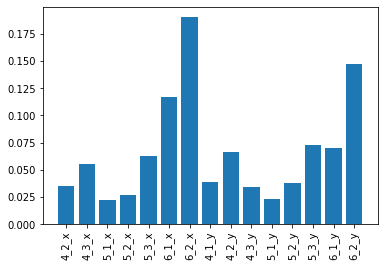

In [145]:
print(f'Best Param:{rfr_cv.best_params_}')
print(f'Feature Importance:{rfr_cv.best_estimator_.feature_importances_}')

bestfea=rfr_cv.best_estimator_.feature_importances_
plt.bar(X.columns,rfr_cv.best_estimator_.feature_importances_)
plt.xticks(rotation=90)

In [146]:
temp_dict={}
temp_lst=[]
for a, b in zip(df_final.columns[-15:],bestfea):
    temp_dict[a]=b
for i,v in temp_dict.items():
    if v >0.05:
        temp_lst.append(i)
temp_lst

['4_3_x', '5_3_x', '6_1_x', '6_2_x', '4_2_y', '5_3_y', '6_1_y', '6_2_y']

In [147]:
#Best model
X=df_final[temp_lst]
y=df_final[['A030 Math']]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=0)
rfr=RandomForestClassifier(random_state=0)
rfr_grid={'n_estimators':np.arange(100,120),'max_depth':np.arange(2,5)}
rfr_cv=GridSearchCV(rfr,rfr_grid,scoring=mk,verbose=1).fit(X_train,y_train)
y_pred=rfr_cv.best_estimator_.predict(X_test)
compare=pd.DataFrame({'pred':y_pred,'actual':y_test['A030 Math']})
compare['diff']=np.abs(compare['pred']-compare['actual'])


Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [148]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.64      0.88      0.74        16
         1.0       0.59      0.62      0.60        26
         2.0       0.87      0.69      0.77        39
         3.0       0.40      0.44      0.42         9
         4.0       0.57      0.57      0.57         7
         5.0       1.00      0.50      0.67         2
         6.0       0.00      0.00      0.00         0

    accuracy                           0.67        99
   macro avg       0.58      0.53      0.54        99
weighted avg       0.70      0.67      0.67        99



Best Param:{'max_depth': 4, 'n_estimators': 112}
Feature Importance:[0.05188704 0.07560633 0.17864763 0.22268258 0.10234441 0.08196282
 0.10986747 0.17700173]


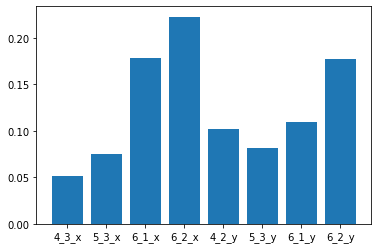

In [149]:
plt.bar(X.columns,rfr_cv.best_estimator_.feature_importances_)
print(f'Best Param:{rfr_cv.best_params_}')
print(f'Feature Importance:{rfr_cv.best_estimator_.feature_importances_}')

In [150]:
#Test 2022 candidates
df2022=df_math[(df_math['學年']==2022 ) & (df_math['班別'].str.contains('6'))]
df2022=df2022[['Reg No.', '學年', '班別', '班號', '中文姓名', '4_1_x', '4_2_x', '4_3_x', '5_1_x', '5_2_x', '5_3_x', '6_1_x', '6_2_x', '4_1_y', '4_2_y', '4_3_y', '5_1_y', '5_2_y', '5_3_y', '6_1_y', '6_2_y']]
df2022[df_final.columns[-15:-8]]=df2022[df_final.columns[-15:-8]].interpolate('linear',axis=1)
df2022[df_final.columns[-8:]]=df2022[df_final.columns[-8:]].interpolate('linear',axis=1)
df2022=df2022.dropna()
sample=df2022[temp_lst]
sample_pred=rfr_cv.best_estimator_.predict(sample)
sample_pred_df=pd.DataFrame({'name':df2022['中文姓名'],'pred':sample_pred})
sample_pred_df.to_excel('DSE2022.xlsx')


Pass rate: 0.41


0.0    30.0
1.0    29.0
2.0    30.0
3.0     5.0
4.0     6.0
5.0     NaN
6.0     NaN
7.0     NaN
Name: pred, dtype: float64

<Axes: >

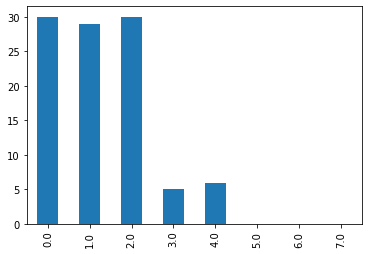

In [151]:
print('Pass rate: ' +str((round((sample_pred_df['pred']>1).sum()/(sample_pred_df['pred']).count(),2))))
display(sample_pred_df['pred'].value_counts().reindex([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0]))
sample_pred_df['pred'].value_counts().reindex([0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0]).plot.bar()

In [152]:
df_top=df_final[df_final['A030 Math']>=5]
df_top=df_top.drop(['A030 Math'],axis=1)
df2022_top=df_math.loc[sample_pred_df[sample_pred_df.pred==4].index]
df_alltop=pd.concat([df_top,df2022_top])
new_lst=['學年','班別','班號','中文姓名','Reg No.']+temp_lst
df_alltop[new_lst]

,學年,班別,班號,中文姓名,Reg No.,4_3_x,5_3_x,6_1_x,6_2_x,4_2_y,5_3_y,6_1_y,6_2_y
859,2016.0,6B,3.0,陳河沅,20144001F,1.507439,2.514688,2.810014,2.363922,1.778014,1.739850,1.713605,1.647688
902,2016.0,6C,16.0,徐浩文,20111037M,1.415068,2.488942,2.312968,2.604246,1.805941,1.730741,1.557823,1.731469
995,2017.0,6C,5.0,石樂兒,20121073F,2.282976,2.438148,2.463491,2.162710,1.703542,1.630540,1.609750,1.656997
1114,2018.0,6C,14.0,陳國聰,20164003M,1.722277,2.178483,1.817001,1.626311,1.219475,1.594103,1.505896,1.452200
1173,2019.0,6A,24.0,徐嘉謙,20141023M,2.373850,2.348493,1.884848,2.155800,1.787323,1.630540,1.661678,1.768705
1174,2019.0,6A,25.0,賴文龍,20141116M,2.398271,2.622707,1.759537,2.130013,1.815250,1.721631,1.618405,1.759396
1181,2019.0,6A,32.0,陸嘉浩,20174001M,2.251745,2.513022,1.960035,2.078437,1.712851,1.685195,1.687642,1.740778
1207,2019.0,6C,7.0,何瑋縉,20141032M,1.690064,2.129121,1.734475,1.743196,1.675615,1.557667,1.609750,1.619761
1298,2020.0,6C,10.0,陳宣亦,20173001M,2.650129,2.181610,2.589471,2.325434,1.852486,1.739850,1.696296,1.768705
1715,2022.0,6A,1.0,鍾欣廷,20171021F,2.338241,1.765960,1.625634,1.473670,1.647688,1.484793,1.402041,1.433582


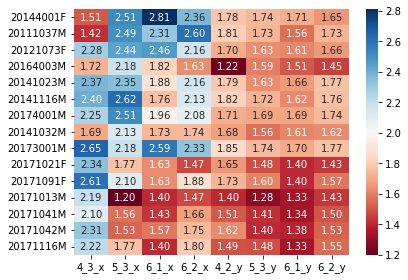

In [ ]:
heat=temp_lst
sns.heatmap(df_alltop[heat],annot=True,fmt='.2f',yticklabels=df_alltop['Reg No.'],cmap='RdBu')
plt.tight_layout()

C:\Users\squar\AppData\Local\Temp\ipykernel_21988\2144022874.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alltopheat[col]=df_alltopheat[col]-df_alltopheat[col].mean()


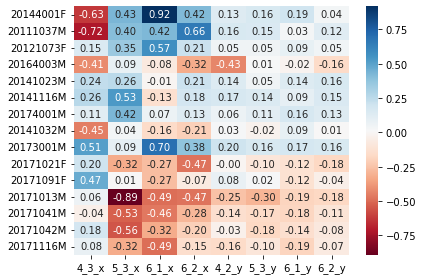

In [106]:
df_alltopheat=df_alltop[heat]
for col in df_alltopheat.columns:
    df_alltopheat[col]=df_alltopheat[col]-df_alltopheat[col].mean()
sns.heatmap(df_alltopheat,annot=True,fmt='.2f',yticklabels=df_alltop['Reg No.'],cmap='RdBu')
plt.tight_layout()

In [107]:
df_mean=df[['學年','班別','班號','中文姓名','T1數學','T2數學']]

df_mean_table=df_mean[df_mean['班別'].str.contains('6')].groupby('學年')['T1數學','T2數學'].mean()
df_mean_table

C:\Users\squar\AppData\Local\Temp\ipykernel_21988\1166050633.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_mean_table=df_mean[df_mean['班別'].str.contains('6')].groupby('學年')['T1數學','T2數學'].mean()


,T1數學,T2數學
學年,,
2014,0.761602,0.703038
2015,0.872966,0.722951
2016,0.774510,0.731798
2017,0.888428,0.855556
2018,0.796468,0.669182
2019,1.010798,0.990495
2020,0.787758,0.794332
2021,0.789039,0.871280
2022,0.748705,0.759959
